# Aufgabe S&P 500 Classifier with PyTorch Lightning
20.11.2021, Thomas Iten

**Inhalt**

1. SP500DataModule (derived from LightningDataModule)
2. SP500ClassifierModel
3. Train and test
4. Run learning finder variation 1: auto_lr_find=True
5. Run learning finder variation 2: trainer.tuner.lr_find
6. Train with early stop and test


## Imports

In [1]:
import os, os.path, requests, datetime
import numpy as np
import pandas as pd
import bs4 as bs
import yfinance

from torch.utils.data import DataLoader, TensorDataset
from typing import Optional

import torch, torchmetrics
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

## 1. SP500DataModule

In [2]:
class SP500DataModule(pl.LightningDataModule):
    """Data module for the 'Standard and Poor 500' company performance data.

    Usage:
    (1) The recommended way to use a DataModule is as follows:
        dm = SP500DataModule()
        model = Model()
        trainer.fit(model, dm)
        trainer.test(datamodule=dm)

    (2) If you need information from the dataset to build your model, then run prepare_data() and setup() manually
        (Lightning ensures the method runs on the correct devices):

        dm = SP500DataModule()
        dm.prepare_data()
        dm.setup(stage="fit")

        model = Model(num_classes=dm.num_classes, width=dm.width, vocab=dm.vocab)
        trainer.fit(model, dm)

        dm.setup(stage="test")
        trainer.test(datamodule=dm)

    Further details see:
    - https://pytorch-lightning.readthedocs.io/en/latest/starter/introduction_guide.html
    - https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html
    """
    URL = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"


    def __init__(self, batch_size=32, train_val_test_split=[75,15,10], spy_binary=True, path="data", force_download=False):
        super().__init__()
        # download properties
        self.start = datetime.datetime(2010, 1, 1)
        self.end = datetime.datetime.now()
        self.fname = path + "/sp500.csv"
        self.force_download = force_download
        # prepare and transform properties
        self.spy_binary = spy_binary
        self.batch_size = batch_size
        self.train_val_test_split = train_val_test_split
        # data
        self.data = None
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None


    def prepare_data(self):
        """Download and prepare the SP500 data."""
        df = self._download_sp500()
        if self.spy_binary:
            df.SPY = [1 if spy > 0 else 0 for spy in df.SPY]
        self.data = df


    def setup(self, stage: Optional[str] = None):
        """Setup the data according the stage 'fit' or 'test'. If the stage is none, setup the data for all stages."""

        # Split data into test, val and train dataframes
        train_percent, val_percent, test_percent = self.train_val_test_split
        rows = self.data.shape[0]
        test_rows = int(test_percent * rows / 100)
        val_rows = int(val_percent * rows / 100)
        train_rows =  rows - test_rows - val_rows

        print("Setup - define data split:")
        print("- Train rows : {0:04d} ( {1}%)".format(train_rows, train_percent))
        print("- Val   rows : {0:04d} ( {1}%)".format(val_rows, val_percent))
        print("- Test  rows : {0:04d} ( {1}%)".format(test_rows, test_percent))
        print("- Total rows : {0:04d} (100%)".format(rows))

        print("Setup - split and transform data for stage: {}".format(stage))
        if stage == "fit" or stage is None:
            train_data = self.data.iloc[:train_rows]
            val_data = self.data.iloc[train_rows:train_rows+val_rows]
            print("- Train shape: {}".format(train_data.shape))
            print("- Val   shape: {}".format(val_data.shape))
            # transform data and assign properties to use in data loaders
            self.train_dataset = self._transform_to_dataset(train_data)
            self.val_dataset = self._transform_to_dataset(val_data)

        if stage == "test" or stage is None:
            test_data = self.data.iloc[train_rows+val_rows:]
            print("- Test  shape: {}".format(test_data.shape))
            # transform data and assign properties to use in data loaders
            self.test_dataset = self._transform_to_dataset(test_data)

        print("- Total shape: {}".format(self.data.shape))


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def _transform_to_dataset(self, df):

        # Split labels and features
        labels = df.SPY.values
        features = df.iloc[:, :-1].values

        # Convert to tensor
        tensor_labels   = torch.tensor(labels).unsqueeze(1).float()
        tensor_features = torch.tensor(features).float()

        # Create tensor dataset
        return TensorDataset(tensor_features, tensor_labels)

    def _download_sp500(self) -> pd.DataFrame:
        """Download the SP500 data from the internet, save data to a csv file and return the result.

        Notes:
        - All further calls will serve the data from the csv file.
        - To trigger a new download from the internet, set the force_download flag to True.
        """

        # Load data from file
        if os.path.isfile(self.fname) and not self.force_download:
            print("Load SP500 from file:", self.fname)
            return pd.read_csv(self.fname, index_col=0, parse_dates=True)

        # Download data
        print("Download data from:", SP500DataModule.URL)
        resp = requests.get(SP500DataModule.URL)
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class': 'wikitable sortable'})

        tickers = []
        for row in table.findAll('tr')[1:]:
            ticker = row.findAll('td')[0].text
            tickers.append(ticker)

        tickers = [s.replace('\n', '') for s in tickers]
        data = yfinance.download(tickers, start=self.start, end=self.end)
        df_data = data['Adj Close']

        df_spy = yfinance.download("SPY", start=self.start, end=self.end)
        df_spy = df_spy.loc[:, ['Adj Close']]
        df_spy.columns = ['SPY']

        df = pd.concat([df_data, df_spy], axis=1)

        # Prepare data
        df.dropna(axis=0, how='all', inplace=True)
        print("Dropping columns due to nans > 50%:", df.loc[:, list((100 * (df.isnull().sum() / len(df.index)) > 50))].columns)
        df = df.drop(df.loc[:, list((100 * (df.isnull().sum() / len(df.index)) > 50))].columns, 1)
        df = df.ffill().bfill()
        print("Any columns still contain nans:", df.isnull().values.any())

        df_returns = pd.DataFrame()
        for name in df.columns:
            df_returns[name] = np.log(df[name]).diff()

        df_returns.dropna(axis=0, how='any', inplace=True)

        # Save data and return result
        print("Save data to file:", self.fname)
        df_returns.to_csv(self.fname)

        self.data = df_returns
        return self.data


## 2. SP500ClassifierModel

In [3]:
class SP500ClassifierModel(pl.LightningModule):

    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.metric = torchmetrics.Accuracy()
        #
        # Model experiments
        #
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(489, 512),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Model experiment 3
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(489, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 1)
        # )
        # Model experiment 2
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(489 , 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 1))
        # Model experiment 1
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(489, 512),
        #     nn.Dropout(.5),
        #     nn.ReLU(),
        #     nn.Linear(512, 64),
        #     nn.Dropout(.5),
        #     nn.ReLU(),
        #     nn.Linear(64, 32),
        #     nn.Dropout(.5),
        #     nn.ReLU(),
        #     nn.Linear(32, 1)
        # )
        #
        # Loss experiments
        #
        self.loss_fn = F.binary_cross_entropy_with_logits
        # Loss experiemnt 1
        # self.loss_fn = nn.BCEWithLogitsLoss()

    def process_step(self, batch, batch_idx):
        x, y = batch
        pred = self.linear_relu_stack(x)
        loss = self.loss_fn(pred, y)

        # calculate accuracy
        pred = (pred>0.5).int()
        acc = self.metric(pred, y.int())

        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx)
        print("val_loss:", loss)
        self.log('val_accuracy', acc)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx)
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        # Update params step: params = params - lr * grad
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## 3. Train and test

### 3.1 Parameters

In [4]:
epochs = 30
batch_size = 48
learning_rate = 0.0001

train_val_test_split=[80,10,10]
gpus = 1 if torch.cuda.is_available() else 0
progress_bar_refresh_rate=16


### 3.2 Train model

In [5]:
datamodule = SP500DataModule(batch_size=batch_size, train_val_test_split=train_val_test_split)
model = SP500ClassifierModel(learning_rate=learning_rate)

trainer = pl.Trainer(gpus=gpus, max_epochs=epochs, progress_bar_refresh_rate=progress_bar_refresh_rate)

trainer.fit(model, datamodule)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Load SP500 from file: data/sp500.csv
Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: fit
- Train shape: (2392, 490)
- Val   shape: (299, 490)
- Total shape: (2990, 490)



  | Name              | Type       | Params
-------------------------------------------------
0 | metric            | Accuracy   | 0     
1 | linear_relu_stack | Sequential | 285 K 
-------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.143     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

val_loss: tensor(0.6899)
val_loss: tensor(0.6900)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6848)
val_loss: tensor(0.6866)
val_loss: tensor(0.6809)
val_loss: tensor(0.6812)
val_loss: tensor(0.6777)
val_loss: tensor(0.6752)
val_loss: tensor(0.6845)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6674)
val_loss: tensor(0.6751)
val_loss: tensor(0.6673)
val_loss: tensor(0.6400)
val_loss: tensor(0.6472)
val_loss: tensor(0.6564)
val_loss: tensor(0.6635)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6127)
val_loss: tensor(0.6369)
val_loss: tensor(0.6237)
val_loss: tensor(0.5075)
val_loss: tensor(0.5491)
val_loss: tensor(0.5987)
val_loss: tensor(0.5978)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.4822)
val_loss: tensor(0.5419)
val_loss: tensor(0.5129)
val_loss: tensor(0.2993)
val_loss: tensor(0.3738)
val_loss: tensor(0.4656)
val_loss: tensor(0.4379)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.3437)
val_loss: tensor(0.4312)
val_loss: tensor(0.3794)
val_loss: tensor(0.1456)
val_loss: tensor(0.2818)
val_loss: tensor(0.3499)
val_loss: tensor(0.2669)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2615)
val_loss: tensor(0.3582)
val_loss: tensor(0.2837)
val_loss: tensor(0.0772)
val_loss: tensor(0.2922)
val_loss: tensor(0.3154)
val_loss: tensor(0.1827)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2280)
val_loss: tensor(0.3269)
val_loss: tensor(0.2364)
val_loss: tensor(0.0529)
val_loss: tensor(0.3411)
val_loss: tensor(0.3354)
val_loss: tensor(0.1653)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2166)
val_loss: tensor(0.3171)
val_loss: tensor(0.2147)
val_loss: tensor(0.0426)
val_loss: tensor(0.3851)
val_loss: tensor(0.3656)
val_loss: tensor(0.1672)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2133)
val_loss: tensor(0.3169)
val_loss: tensor(0.1999)
val_loss: tensor(0.0358)
val_loss: tensor(0.4187)
val_loss: tensor(0.3894)
val_loss: tensor(0.1699)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2110)
val_loss: tensor(0.3168)
val_loss: tensor(0.1909)
val_loss: tensor(0.0312)
val_loss: tensor(0.4360)
val_loss: tensor(0.4056)
val_loss: tensor(0.1698)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2104)
val_loss: tensor(0.3189)
val_loss: tensor(0.1876)
val_loss: tensor(0.0288)
val_loss: tensor(0.4536)
val_loss: tensor(0.4268)
val_loss: tensor(0.1746)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2098)
val_loss: tensor(0.3202)
val_loss: tensor(0.1858)
val_loss: tensor(0.0268)
val_loss: tensor(0.4641)
val_loss: tensor(0.4429)
val_loss: tensor(0.1767)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2085)
val_loss: tensor(0.3195)
val_loss: tensor(0.1784)
val_loss: tensor(0.0238)
val_loss: tensor(0.4664)
val_loss: tensor(0.4419)
val_loss: tensor(0.1697)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2074)
val_loss: tensor(0.3193)
val_loss: tensor(0.1739)
val_loss: tensor(0.0216)
val_loss: tensor(0.4734)
val_loss: tensor(0.4501)
val_loss: tensor(0.1659)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2056)
val_loss: tensor(0.3191)
val_loss: tensor(0.1720)
val_loss: tensor(0.0201)
val_loss: tensor(0.4768)
val_loss: tensor(0.4592)
val_loss: tensor(0.1644)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2038)
val_loss: tensor(0.3171)
val_loss: tensor(0.1692)
val_loss: tensor(0.0185)
val_loss: tensor(0.4767)
val_loss: tensor(0.4658)
val_loss: tensor(0.1604)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2022)
val_loss: tensor(0.3159)
val_loss: tensor(0.1652)
val_loss: tensor(0.0168)
val_loss: tensor(0.4765)
val_loss: tensor(0.4671)
val_loss: tensor(0.1557)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2021)
val_loss: tensor(0.3157)
val_loss: tensor(0.1606)
val_loss: tensor(0.0152)
val_loss: tensor(0.4812)
val_loss: tensor(0.4718)
val_loss: tensor(0.1471)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2016)
val_loss: tensor(0.3165)
val_loss: tensor(0.1587)
val_loss: tensor(0.0142)
val_loss: tensor(0.4845)
val_loss: tensor(0.4814)
val_loss: tensor(0.1457)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2003)
val_loss: tensor(0.3150)
val_loss: tensor(0.1561)
val_loss: tensor(0.0131)
val_loss: tensor(0.4848)
val_loss: tensor(0.4850)
val_loss: tensor(0.1419)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2003)
val_loss: tensor(0.3138)
val_loss: tensor(0.1492)
val_loss: tensor(0.0116)
val_loss: tensor(0.4867)
val_loss: tensor(0.4813)
val_loss: tensor(0.1295)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1962)
val_loss: tensor(0.3120)
val_loss: tensor(0.1528)
val_loss: tensor(0.0115)
val_loss: tensor(0.4897)
val_loss: tensor(0.4991)
val_loss: tensor(0.1390)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1957)
val_loss: tensor(0.3095)
val_loss: tensor(0.1464)
val_loss: tensor(0.0101)
val_loss: tensor(0.4897)
val_loss: tensor(0.4973)
val_loss: tensor(0.1252)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1971)
val_loss: tensor(0.3093)
val_loss: tensor(0.1395)
val_loss: tensor(0.0089)
val_loss: tensor(0.4936)
val_loss: tensor(0.4970)
val_loss: tensor(0.1114)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1962)
val_loss: tensor(0.3056)
val_loss: tensor(0.1338)
val_loss: tensor(0.0082)
val_loss: tensor(0.4925)
val_loss: tensor(0.4940)
val_loss: tensor(0.1006)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1953)
val_loss: tensor(0.3040)
val_loss: tensor(0.1297)
val_loss: tensor(0.0077)
val_loss: tensor(0.4929)
val_loss: tensor(0.4943)
val_loss: tensor(0.0922)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1920)
val_loss: tensor(0.3015)
val_loss: tensor(0.1291)
val_loss: tensor(0.0071)
val_loss: tensor(0.4940)
val_loss: tensor(0.5051)
val_loss: tensor(0.0877)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1923)
val_loss: tensor(0.3005)
val_loss: tensor(0.1241)
val_loss: tensor(0.0066)
val_loss: tensor(0.4981)
val_loss: tensor(0.5031)
val_loss: tensor(0.0809)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1930)
val_loss: tensor(0.3017)
val_loss: tensor(0.1184)
val_loss: tensor(0.0060)
val_loss: tensor(0.5012)
val_loss: tensor(0.4998)
val_loss: tensor(0.0703)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1899)
val_loss: tensor(0.2978)
val_loss: tensor(0.1181)
val_loss: tensor(0.0057)
val_loss: tensor(0.5000)
val_loss: tensor(0.5060)
val_loss: tensor(0.0725)


### 3.3 Test model

In [6]:
trainer.test(datamodule=datamodule)


Restoring states from the checkpoint path at D:\dev\workspace\surfmachine\ai\src\04_pytorch_lightning_sp500_classifier\lightning_logs\version_2\checkpoints\epoch=29-step=1499.ckpt
Loaded model weights from checkpoint at D:\dev\workspace\surfmachine\ai\src\04_pytorch_lightning_sp500_classifier\lightning_logs\version_2\checkpoints\epoch=29-step=1499.ckpt


Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: test
- Test  shape: (299, 490)
- Total shape: (2990, 490)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8528428077697754, 'test_loss': 0.47495007514953613}
--------------------------------------------------------------------------------


[{'test_loss': 0.47495007514953613, 'test_accuracy': 0.8528428077697754}]

## 4. Run learning finder variation 1: auto_lr_find=True

In [7]:
datamodule = SP500DataModule(batch_size=batch_size, train_val_test_split=train_val_test_split)
model = SP500ClassifierModel(learning_rate=learning_rate)

trainer = pl.Trainer(gpus=gpus, max_epochs=epochs, progress_bar_refresh_rate=progress_bar_refresh_rate, auto_lr_find=True)

trainer.tune(model, datamodule)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Load SP500 from file: data/sp500.csv
Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: fit
- Train shape: (2392, 490)
- Val   shape: (299, 490)
- Total shape: (2990, 490)
val_loss: tensor(0.7052)
val_loss: tensor(0.7053)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

val_loss: tensor(0.7041)
val_loss: tensor(0.7045)
val_loss: tensor(0.7166)
val_loss: tensor(0.6903)
val_loss: tensor(0.7094)
val_loss: tensor(0.7254)
val_loss: tensor(0.7013)


Restoring states from the checkpoint path at D:\dev\workspace\surfmachine\ai\src\04_pytorch_lightning_sp500_classifier\lr_find_temp_model_d5ef2a7c-9982-429d-a25f-9a5483a53bf2.ckpt
Learning rate set to 0.01445439770745928


val_loss: tensor(224.0790)
val_loss: tensor(118.3708)
val_loss: tensor(124.5415)
val_loss: tensor(302.0559)
val_loss: tensor(94.2377)
val_loss: tensor(92.2275)
val_loss: tensor(243.7720)


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x2188e1fe8e0>}

## 5. Run learning finder variation 2: trainer.tuner.lr_find

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Load SP500 from file: data/sp500.csv
Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: fit
- Train shape: (2392, 490)
- Val   shape: (299, 490)
- Total shape: (2990, 490)
val_loss: tensor(0.7045)
val_loss: tensor(0.7044)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

val_loss: tensor(0.7038)
val_loss: tensor(0.7040)
val_loss: tensor(0.7155)
val_loss: tensor(0.6914)
val_loss: tensor(0.7091)
val_loss: tensor(0.7241)
val_loss: tensor(0.7013)


Restoring states from the checkpoint path at D:\dev\workspace\surfmachine\ai\src\04_pytorch_lightning_sp500_classifier\lr_find_temp_model_c4a88dbd-2f74-4a65-89cf-dd11218c78c8.ckpt


val_loss: tensor(0.6866)
val_loss: tensor(0.6866)
val_loss: tensor(0.6740)
val_loss: tensor(0.6991)
val_loss: tensor(0.6803)
val_loss: tensor(0.6646)
val_loss: tensor(0.6891)
{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.1201083

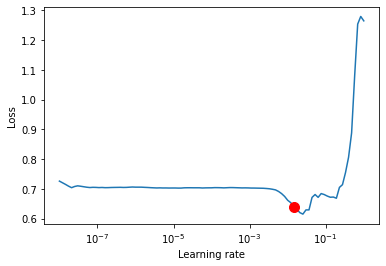

In [8]:
datamodule = SP500DataModule(batch_size=batch_size, train_val_test_split=train_val_test_split)
model = SP500ClassifierModel(learning_rate=learning_rate)

trainer = pl.Trainer(min_epochs=5)
lr_finder = trainer.tuner.lr_find(model, datamodule)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

# update hparams of the model
model.hparams.lr = new_lr


## 6. Train with early stop and test

In [9]:
early_stop_callback = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")

# saves a file like: my/path/sample-mnist-epoch=02-val_loss=0.32.ckpt
if not os.path.exists('models'):
    os.makedirs('models')

checkpoint_callback = ModelCheckpoint(
    monitor="val_accuracy",
    dirpath="models",
    filename="sp500-{epoch:02d}-{val_accuracy:.2f}",
    save_top_k = 5,
    mode="max"
)

trainer = pl.Trainer(callbacks=[early_stop_callback, checkpoint_callback], progress_bar_refresh_rate=progress_bar_refresh_rate, max_epochs=epochs)

trainer.fit(model, datamodule)
trainer.test(datamodule=datamodule)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name              | Type       | Params
-------------------------------------------------
0 | metric            | Accuracy   | 0     
1 | linear_relu_stack | Sequential | 285 K 
-------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.143     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

val_loss: tensor(0.7045)
val_loss: tensor(0.7044)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6983)
val_loss: tensor(0.7000)
val_loss: tensor(0.7104)
val_loss: tensor(0.6777)
val_loss: tensor(0.6991)
val_loss: tensor(0.7169)
val_loss: tensor(0.6945)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6814)
val_loss: tensor(0.6888)
val_loss: tensor(0.6974)
val_loss: tensor(0.6352)
val_loss: tensor(0.6713)
val_loss: tensor(0.7002)
val_loss: tensor(0.6733)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6325)
val_loss: tensor(0.6556)
val_loss: tensor(0.6605)
val_loss: tensor(0.5072)
val_loss: tensor(0.5869)
val_loss: tensor(0.6551)
val_loss: tensor(0.6131)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.5085)
val_loss: tensor(0.5686)
val_loss: tensor(0.5635)
val_loss: tensor(0.2895)
val_loss: tensor(0.4026)
val_loss: tensor(0.5413)
val_loss: tensor(0.4606)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.3539)
val_loss: tensor(0.4477)
val_loss: tensor(0.4224)
val_loss: tensor(0.1432)
val_loss: tensor(0.2734)
val_loss: tensor(0.4137)
val_loss: tensor(0.2870)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2582)
val_loss: tensor(0.3631)
val_loss: tensor(0.3072)
val_loss: tensor(0.0801)
val_loss: tensor(0.2741)
val_loss: tensor(0.3549)
val_loss: tensor(0.1966)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2215)
val_loss: tensor(0.3285)
val_loss: tensor(0.2475)
val_loss: tensor(0.0546)
val_loss: tensor(0.3218)
val_loss: tensor(0.3597)
val_loss: tensor(0.1736)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2096)
val_loss: tensor(0.3181)
val_loss: tensor(0.2194)
val_loss: tensor(0.0426)
val_loss: tensor(0.3686)
val_loss: tensor(0.3860)
val_loss: tensor(0.1745)


Validating: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at D:\dev\workspace\surfmachine\ai\src\04_pytorch_lightning_sp500_classifier\models\sp500-epoch=05-val_accuracy=0.88.ckpt
Loaded model weights from checkpoint at D:\dev\workspace\surfmachine\ai\src\04_pytorch_lightning_sp500_classifier\models\sp500-epoch=05-val_accuracy=0.88.ckpt


val_loss: tensor(0.2062)
val_loss: tensor(0.3164)
val_loss: tensor(0.2075)
val_loss: tensor(0.0361)
val_loss: tensor(0.4064)
val_loss: tensor(0.4196)
val_loss: tensor(0.1829)
Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: test
- Test  shape: (299, 490)
- Total shape: (2990, 490)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8561872839927673, 'test_loss': 0.34729865193367004}
--------------------------------------------------------------------------------


[{'test_loss': 0.34729865193367004, 'test_accuracy': 0.8561872839927673}]

---
The end.